In [1]:
from collections import defaultdict

from qtranspiler.architectures import Grid
from qtranspiler.routing.algorithms import approx_token_swapping
from qtranspiler.routing.grid_routing import grid_route_two_directions
from qtranspiler.utils import blocked_random_map, local_random_permutations, random_map
from qtranspiler.utils import Profile

from matplotlib import pyplot as plt

num_runs = 10
b_size = '4by4'
window = "window_2"

grid_dimensions = [(4, 4), (8, 4), (8, 8), (16, 4), (16, 8), (16, 16), (32, 8),
                   (32, 16), (64, 8), (24, 24), (32, 24), (32, 32), (64, 16)]

block_sizes = [(2, 2), (2, 2), (2, 2), (4, 2), (4, 4), (4, 4), (4, 4), (4, 4),
               (4, 4), (4, 4), (4, 4), (4, 4), (4, 4)]


def new_label_generator(algorithm, grids, block_sizes=None):
    if algorithm is local_random_permutations:
        return [
            local_random_permutations(grid, block[0] * block[1], *block)
            for grid, block in zip(grids, block_sizes)
        ]
    elif algorithm is blocked_random_map:
        return [
            blocked_random_map(grid, *block)
            for grid, block in zip(grids, block_sizes)
        ]
    elif algorithm is random_map:
        return [random_map(grid) for grid in grids]
    else:
        raise ValueError(f"Unknown mapping algorithm {algorithm}")


def is_local(locality):
    if locality:
        return 'local'
    return 'nonlocal'


def get_func_name(func):
    if not callable(func):
        raise TypeError(f"{func} is not a callable")
    if 'grid_route' == func.__name__:
        return "Grid Route"
    elif 'grid_route_two_directions' == func.__name__:
        return "Grid Route in 2 Directions"
    elif 'approx_token_swapping' == func.__name__:
        return "Approximate Token Swapping"
    else:
        return (func.__name__)


algorithms = (grid_route_two_directions, approx_token_swapping)
mapping_functions = (blocked_random_map, local_random_permutations, random_map)
locality = (True, )

grids = [Grid(*grid) for grid in grid_dimensions]

maps = defaultdict(list)
for _ in range(num_runs):
    for m_func in mapping_functions:
        maps[m_func].append(new_label_generator(m_func, grids, block_sizes))

runs = defaultdict(list)

for idx, g in enumerate(grids):
    for m in mapping_functions:
        for l in locality:
            for algo in algorithms:
                run = Profile(algo)
                for i in range(num_runs):
                    if algo is approx_token_swapping:
                        run.add_run(g, maps[m][i][idx].flatten())
                    else:
                        run.add_run(g.numpy_array(), maps[m][i][idx], l)
                runs[(algo, m, l)].append(run)


<Figure size 432x288 with 0 Axes>

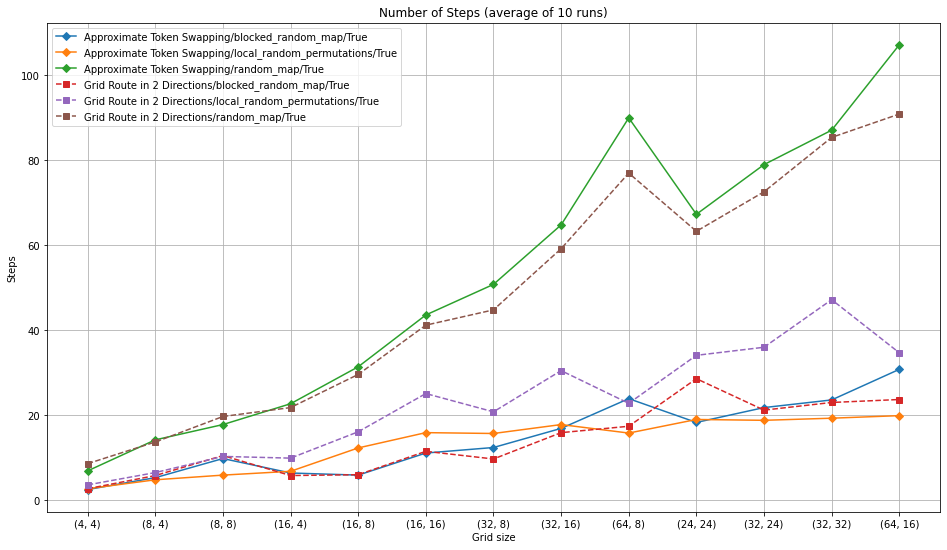

In [2]:
plt.figure(1)
plt.figure(figsize=(16, 9))
sizes = [str(g.shape) for g in grids]

for key, value in sorted(runs.items(), key=lambda k: str(k[0])):
    algorithm = get_func_name(key[0])
    if algorithm == 'Approximate Token Swapping':
        marker = '-D'
    elif algorithm == "Grid Route":
        marker = ':H'
    else:
        marker = '--s'
    mapping_function = key[1].__name__
    locality = key[2]
    num_steps = [run.average_value(len) for run in value]
    plt.plot(sizes,
             num_steps,
             marker,
             label=f'{algorithm}/{mapping_function}/{locality}')

plt.legend()
plt.grid(True)
plt.xlabel('Grid size')
plt.ylabel('Steps')
plt.title(f'Number of Steps (average of {num_runs} runs)')
# plt.show()
plt.savefig(f"ipdps/steps-{b_size}-{window}.png")

<Figure size 432x288 with 0 Axes>

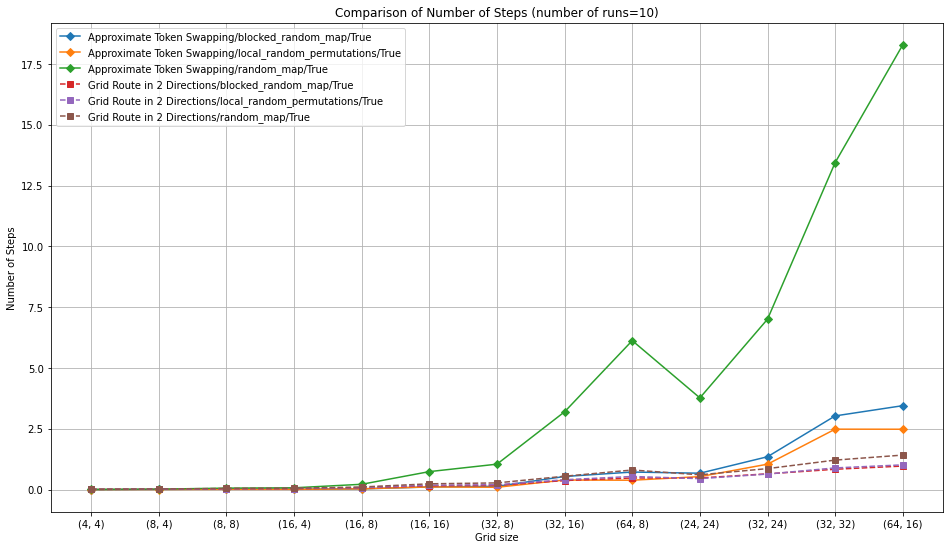

In [3]:
plt.figure(2)
plt.figure(figsize=(16, 9))
sizes = [str(g.shape) for g in grids]

for key, value in sorted(runs.items(), key=lambda k: str(k[0])):
    algorithm = get_func_name(key[0])
    if algorithm == 'Approximate Token Swapping':
        marker = '-D'
    elif algorithm == "Grid Route":
        marker = ':H'
    else:
        marker = '--s'
    mapping_function = key[1].__name__
    locality = key[2]
    timings = [run.average_time() for run in value]
    plt.plot(sizes,
             timings,
             marker,
             label=f'{algorithm}/{mapping_function}/{locality}')

plt.legend()
plt.grid(True)
plt.xlabel('Grid size')
plt.ylabel('Number of Steps')
plt.title(f'Comparison of Number of Steps (number of runs={num_runs})')
# plt.show()
plt.savefig(f"ipdps/timings-{b_size}-{window}.png")